# Considerations

#### What is the Airbnb business model?

- Marketplace: connect people offering homestays with people looking for homestays.
                  
- Gross Revenue = (Fee * Users) - CAC

# Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random

from IPython.display import Image
from matplotlib import pyplot as plt
from keras import models as ml
from keras import layers as l
from scikitplot import metrics as mt
from scipy import stats as ss

from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics as m

2023-01-12 19:55:56.853061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Helper Functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

## Loading Data

In [3]:
data_raw_age_gender = pd.read_csv("datasets/age_gender_bkts.csv", low_memory=False)
data_raw_age_gender

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0
...,...,...,...,...,...
415,95-99,US,male,115.0,2015.0
416,90-94,US,male,541.0,2015.0
417,15-19,US,female,10570.0,2015.0
418,85-89,US,male,1441.0,2015.0


In [4]:
data_raw_countries = pd.read_csv("datasets/countries.csv", low_memory=False)
data_raw_countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [5]:
data_raw_sample_submission = pd.read_csv("datasets/sample_submission_NDF.csv", low_memory=False)
data_raw_sample_submission

,id,country
0,5uwns89zht,NDF
1,jtl0dijy2j,NDF
2,xx0ulgorjt,NDF
3,6c6puo6ix0,NDF
4,czqhjk3yfe,NDF
...,...,...
62091,cv0na2lf5a,NDF
62092,zp8xfonng8,NDF
62093,fa6260ziny,NDF
62094,87k0fy4ugm,NDF


In [6]:
df_sessions = pd.read_csv("datasets/sessions.csv", low_memory=True)
df_sessions

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
...,...,...,...,...,...,...
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556.0
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624.0
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125.0
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624.0


In [7]:
data_raw_test_users = pd.read_csv("datasets/test_users.csv", low_memory=False)
data_raw_test_users

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62091,cv0na2lf5a,2014-09-30,20140930235232,NaN,-unknown-,31.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE
62092,zp8xfonng8,2014-09-30,20140930235306,NaN,-unknown-,NaN,basic,23,ko,direct,direct,untracked,Android,Android Phone,-unknown-
62093,fa6260ziny,2014-09-30,20140930235408,NaN,-unknown-,NaN,basic,0,de,direct,direct,linked,Web,Windows Desktop,Firefox
62094,87k0fy4ugm,2014-09-30,20140930235430,NaN,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari


In [8]:
data_raw_train_users = pd.read_csv("datasets/train_users_2.csv", low_memory=False)
data_raw_train_users

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


#### Could we merge sesions with train_users?

Sessions and train_users are our main tables. We are going to use both of them in this project. Yet, we cannot merge these tables now because they have different granularity: 

**(1)** train_user is user-level (informations are: one user per row). 

**(2)** sessions is secs_elapsed-level (informations are related to action, action_type, action_detail, device_type and secs_elapse - and this one is the highest level).

To merge the two tables, we need to encoding the columns from sessions. 

In [9]:
# train user
data_raw_train_users[data_raw_train_users["id"] == "nw9fwlyb5f"]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
213450,nw9fwlyb5f,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF


In [10]:
# sessions
df_sessions[df_sessions["user_id"] == "nw9fwlyb5f"].head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
5555239,nw9fwlyb5f,show,view,user_profile,iPhone,9310.0
5555240,nw9fwlyb5f,show,view,p3,iPhone,33.0
5555241,nw9fwlyb5f,reviews,data,listing_reviews,iPhone,8.0
5555242,nw9fwlyb5f,campaigns,NaN,NaN,iPhone,41983.0
5555243,nw9fwlyb5f,click,click,book_it,iPhone,58491.0


In [11]:
# sessions
df_sessions[(df_sessions["user_id"] == "nw9fwlyb5f") & (df_sessions["action"] == "reviews")].head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
5555241,nw9fwlyb5f,reviews,data,listing_reviews,iPhone,8.0
5555269,nw9fwlyb5f,reviews,data,listing_reviews,iPhone,11.0


# 1. Data Description

In [12]:
df1 = data_raw_train_users.copy()

### Data fields meaning

- id: user id.

- date_account_created: the date of account creation.

- timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or - date_first_booking because a user can search before signing up.

- date_first_booking: date of first booking.

- gender.

- age.

- signup_method.

- signup_flow: the page a user came to signup up from.

- language: international language preference.

- affiliate_channel: what kind of paid marketing.

- affiliate_provider: where the marketing is e.g. google, craigslist, other.

- first_affiliate_tracked: whats the first marketing the user interacted with before the signing up.

- signup_app.

- first_device_type.

- first_browser.

- country_destination: this is the target variable you are to predict.

## 1.1. Data Dimensions

In [13]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 213451
Number of cols: 16


In [14]:
print("Number of rows: {}".format(df_sessions.shape[0]))
print("Number of cols: {}".format(df_sessions.shape[1]))

Number of rows: 10567737
Number of cols: 6


## 1.2. Data Types

In [15]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [16]:
df1.sample(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
81068,4y13jw11wf,2013-06-02,20130602055418,2013-06-04,FEMALE,52.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,US
50043,jvjkhof19c,2012-11-27,20121127185928,NaN,FEMALE,37.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
191691,pz35maiiyv,2014-05-19,20140519191354,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,NDF


In [17]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

In [18]:
df_sessions.sample(3)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
1617640,n7q85ldw08,search_results,click,view_search_results,Mac Desktop,16934.0
5407391,w4p5bibfk3,ajax_refresh_subtotal,click,change_trip_characteristics,Mac Desktop,33.0
5315000,oylazewplw,search,click,view_search_results,iPhone,51716.0


## 1.3. NA Check

In [19]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [20]:
df1.isna().sum()/len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [21]:
df_sessions.isna().sum()/len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

The percentage of NA values of date_first_booking is very high. We must check the proportion of NA values for this column related to our classes:

In [22]:
aux = df1[df1["date_first_booking"].isna()]
aux["country_destination"].value_counts(normalize=True)

NDF    1.0
Name: country_destination, dtype: float64

- All NA values from date_first_booking class are from country_destinarion = NDF. 
- People who do not have a destination country does not have date first booking.
- A solution is to replace this Na values with the maximum date of our dataset. 

Similarly, let's analyze the column age:

In [23]:
aux = df1[df1["age"].isna()]
aux["country_destination"].value_counts(normalize=True)

NDF      0.768428
US       0.156529
other    0.028617
FR       0.014888
IT       0.009081
GB       0.006251
ES       0.006171
CA       0.003989
DE       0.002387
NL       0.001818
AU       0.001171
PT       0.000671
Name: country_destination, dtype: float64

We must see how the data distribution is. If our distribution is close to a normal one, we must fill NA values with the average age. As we may see below, we may do this treatment for column age. 

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

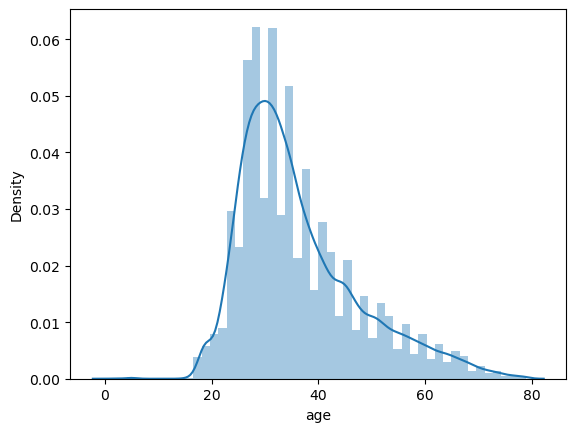

In [24]:
# assumption to see the chart: low incidence of people using Airbnb older than 80 years
sns.distplot(df1[df1["age"] < 80]["age"])

The column first_affiliate_tracked is a categorical one. Replace NA values for this column with any other string may generate a high biased model. As we have only 2.8% of NA values from this column, we may remove all NA values. 

**Suggestion:** In case we had a categorical feature, but with a high percentage of NA values, we could collect more data instead of removing all NA values from that column.

In [25]:
df1["first_affiliate_tracked"].unique()

array(['untracked', 'omg', nan, 'linked', 'tracked-other', 'product',
       'marketing', 'local ops'], dtype=object)

## 1.4. Removing NA

**First cycle:** As we want to deliver a solution as faster as possible, we will remove all NA values in this cycle. However, we may treat NA values using a different technique as next steps.

**Second cycle:** We face some problems by removing NA values.

- Loss of relevant information from columns.
- Data volume decrase to train models.

There are thre manners to remove NA values from our dataset: (1) Business, (2) Statistical and (3) Machine Learning. For further details, check my portfolio project named **Rossmann Store Sales**. 

In [26]:
# ========== User =================

# date_first_booking
date_first_booking_max = pd.to_datetime( df1['date_first_booking'] ).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age
df1_sample = df1[(df1['age'] > 15) & (df1['age'] < 122)]
avg_age = np.round(df1_sample['age'].mean(), 0)
df1['age'] = df1['age'].fillna(avg_age)

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ========== Sessions ==============

# user_id - 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]

# action_type - 11% (total rows amount: more than 10 millions)
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_detail - 11% (total rows amount: more than 10 millions)
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

## 1.5. Change Data Type

In [27]:
# date_account_created
df1["date_account_created"] = pd.to_datetime(df1["date_account_created"])

# timestamp_first_active
df1["timestamp_first_active"] = pd.to_datetime(df1["timestamp_first_active"], format="%Y%m%d%H%M%S")

# date_first_booking
df1["date_first_booking"] = pd.to_datetime(df1["date_first_booking"])

# age
df1["age"] = df1["age"].astype(int)

In [28]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.6. Check Balanced Data

In [29]:
df1["country_destination"].value_counts()

NDF      120216
US        61067
other      9981
FR         4899
IT         2791
GB         2295
ES         2213
CA         1391
DE         1041
NL          751
AU          527
PT          214
Name: country_destination, dtype: int64

In [30]:
df1["country_destination"].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

- This is a multi-class (many types for the target variable) and very unbalanced (70% of data only for US, for instance). This is a very complex classification problem. 

- Since NDF (no destination found) was a type of country_destination, it is not in our dataset anymore because it belongs to users which did not make their first booking - and we removed these NA values. 

## 1.7. Descriptive Statistics

This section is to find inconsistencies, anomalies and also the main characteristics of our data.

In [31]:
# Users
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes = df1.select_dtypes(include=['datetime64[ns]'])

# Sessions
num_attributes_sessions = df_sessions.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions = df_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.7.1. Numerical attributes - Users

In [32]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenar
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,1.0,2014.0,2013.0,44.325128,37.0,118.575595,16.392840,268.929431
1,signup_flow,0.0,25.0,25.0,3.151490,0.0,7.543915,2.287158,3.567794


- We have maximum age as 2014. This is probably wrong.
- As median is less than mean, we have a left skew: positive skewness. 
- Since age has a 269 value for kurtosis, we have a very high peak.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


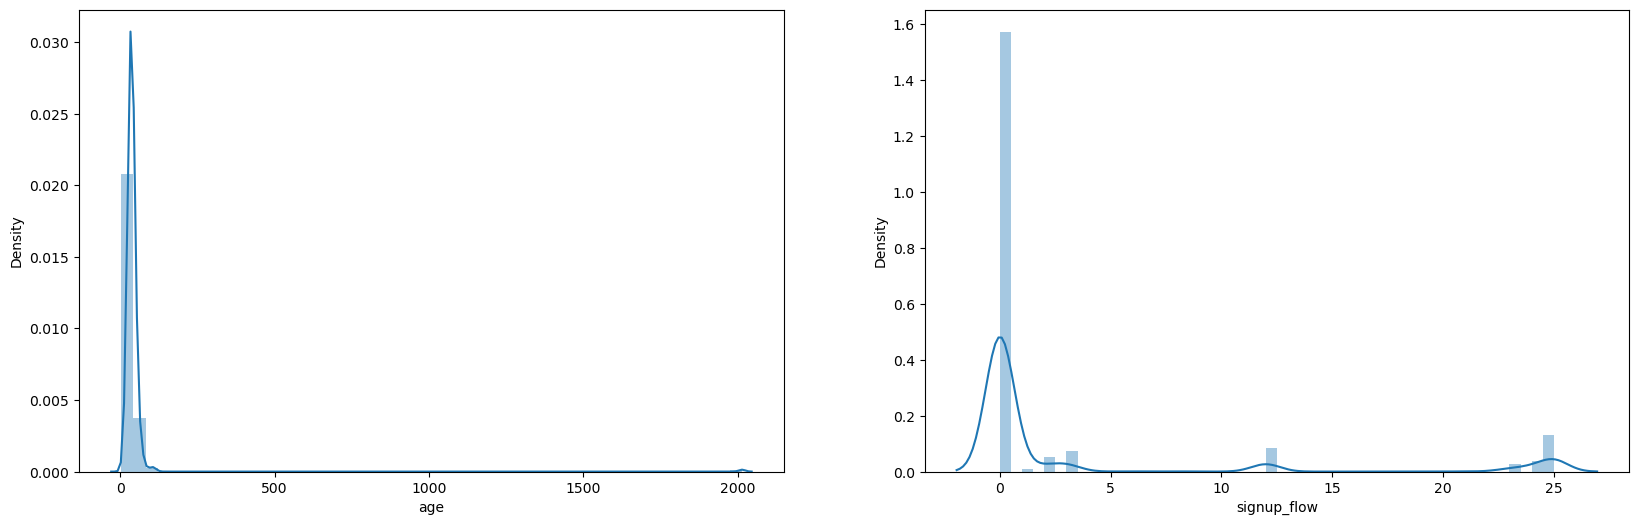

In [33]:
plt.figure(figsize = (20,6))

plt.subplot(121)
sns.distplot(df1["age"])

plt.subplot(122)
sns.distplot(df1["signup_flow"])

plt.subplots_adjust(wspace = 0.2)

We may have lower ages ( <= 2 years old, for instance) in our dataset because they are children accompanied by parents. Yet, we may not have ages higher than 122, since this age is for the oldest person who ever lived on Earth. Thus, these values will be treated as outliers.

### 1.7.2. Numerical Attributes - Sessions

In [34]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame( num_attributes_sessions.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes_sessions.apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes_sessions.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes_sessions.apply( min ) ).T
d3 = pd.DataFrame( num_attributes_sessions.apply( max ) ).T
d4 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='secs_elapsed', ylabel='Density'>

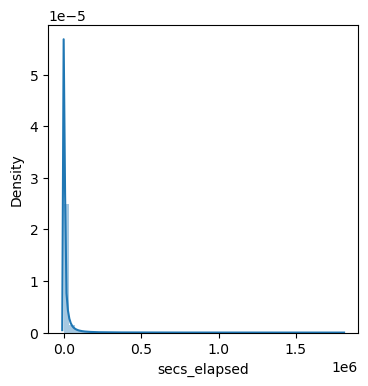

In [35]:
plt.figure(figsize =(4,4))

sns.distplot(df_sessions["secs_elapsed"])

- secs_elpased is the time a user stays on webpage. A value equals zero is not realistic. 
- A maximum value of 1799977.0 seconds is either not realistic, because it represents around 208 days.

### 1.7.3. Categorical Attributes - Users

In [36]:
cat_attributes.apply(lambda x: x.unique().shape[0])

id                         207386
gender                          4
signup_method                   3
language                       25
affiliate_channel               8
affiliate_provider             18
first_affiliate_tracked         7
signup_app                      4
first_device_type               9
first_browser                  52
country_destination            12
dtype: int64

In [37]:
cat_attributes.drop(columns="id").apply(lambda x: x.unique())

gender                                      [-unknown-, MALE, FEMALE, OTHER]
signup_method                                      [facebook, basic, google]
language                   [en, fr, de, es, pt, zh, ko, ja, it, ru, pl, e...
affiliate_channel          [direct, seo, other, sem-non-brand, content, s...
affiliate_provider         [direct, google, other, craigslist, facebook, ...
first_affiliate_tracked    [untracked, omg, linked, tracked-other, produc...
signup_app                                        [Web, Moweb, iOS, Android]
first_device_type          [Mac Desktop, Windows Desktop, iPhone, Other/U...
first_browser              [Chrome, IE, Firefox, Safari, -unknown-, Mobil...
country_destination        [NDF, US, other, CA, FR, ES, GB, IT, PT, NL, D...
dtype: object

In [38]:
cat_attributes.drop("id", axis=1).describe().T

,count,unique,top,freq
gender,207386,4,-unknown-,91783
signup_method,207386,3,basic,148297
language,207386,25,en,200415
affiliate_channel,207386,8,direct,134179
affiliate_provider,207386,18,direct,133935
first_affiliate_tracked,207386,7,untracked,109232
signup_app,207386,4,Web,178334
first_device_type,207386,9,Mac Desktop,89600
first_browser,207386,52,Chrome,63845
country_destination,207386,12,NDF,120216


- Some features have a higher number of unique values. This makes one hot encoding very inappropriate. 
- If there are correlation between these categorical variables, we may remove some of them.

### 1.7.4. Categorical Attributes - Sessions

In [39]:
cat_attributes_sessions.apply(lambda x: x.unique().shape[0])

user_id          133878
action              347
action_type          10
action_detail       155
device_type          14
dtype: int64

In [40]:
cat_attributes_sessions.drop(columns="user_id").apply(lambda x: x.unique())

action           [search_results, personalize, index, similar_l...
action_type      [click, data, view, submit, -unknown-, booking...
action_detail    [view_search_results, wishlist_content_update,...
device_type      [Windows Desktop, -unknown-, Mac Desktop, Andr...
dtype: object

In [41]:
cat_attributes_sessions.drop("user_id", axis=1).describe().T

,count,unique,top,freq
action,9213930,347,show,2178382
action_type,9213930,10,view,3545621
action_detail,9213930,155,view_search_results,1770931
device_type,9213930,14,Mac Desktop,3019523


### 1.7.5. Correlation Matrix - Users

If there are correlation between categorical variables, we may remove some of them. To evaluate correlation between categorical variables, we use Cramer's V method. 

In [42]:
cat_attributes_list = cat_attributes.drop('id', axis=1).columns.tolist()

corr_dict = {}
for i in range( len (cat_attributes_list)):
    corr_list = []
    for j in range(len( cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ref] = corr_list

<AxesSubplot:>

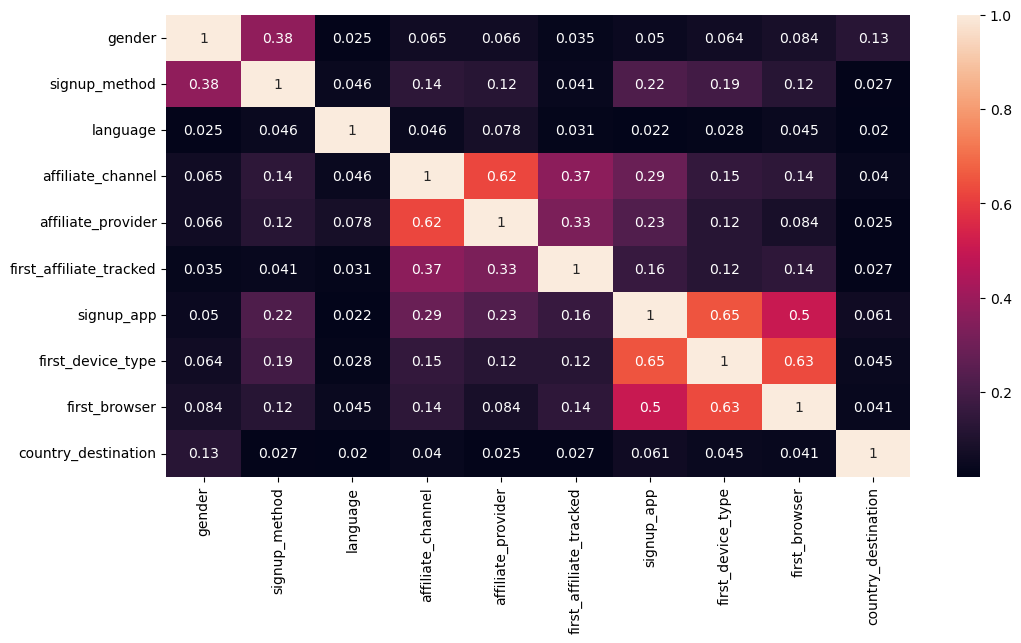

In [43]:
plt.figure(figsize =(12,6))

d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns)
sns.heatmap( d, annot=True )

Score for Cramer's V from 0 to 1. Thus, very correlated features are those higher than 60%:

1. first_device_type and signup_app: 0.65.
2. first_browser and first_device_type: 0.63. 
3. affiliate_provider and affiliate_channel: 0.62.

Choice:

1. signup_app: 4 unique values.
2. first_device_type: 9 unique values.
3. affiliate_channel: 8 unique values.
4. signup_app: 4 unique values. 

The columns that we may remove are: first_device_type, first_browser and affiliate_provider. 

### 1.7.6. Correlation Matrix - Sessions

In [44]:
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}
for i in range( len ( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ref] = corr_list

<AxesSubplot:>

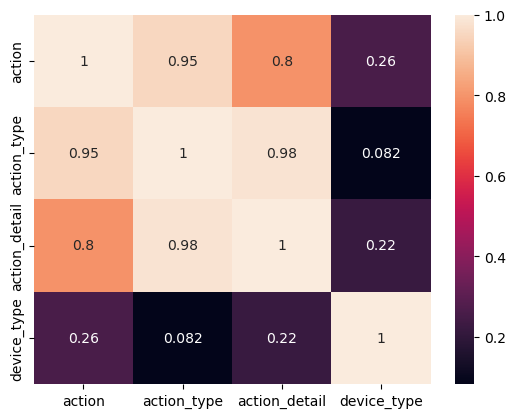

In [45]:
d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns)
sns.heatmap( d, annot=True )

Most correlated features based on Cramer's V score:

1. action_detail and action_type: 0.98.
2. action_type and action: 0.95.
3. action_detail and action: 0.80. 

Based on the analysis done in the section 1.7.4, action detail has 155 unique classes while action_type has 10. Action detail is 98% represented by action_type. Thus, we may keep only action_type, which is the one with less classes. Similarly, we chose the following features:

1. action_type.
2. action_type.
3. action_detail. 

Thus, we may remove action_detail and action columns.

# 2. Feature Engineering

In [46]:
df2 = df1.copy()

## 2.1. Hypotheses Mind Map

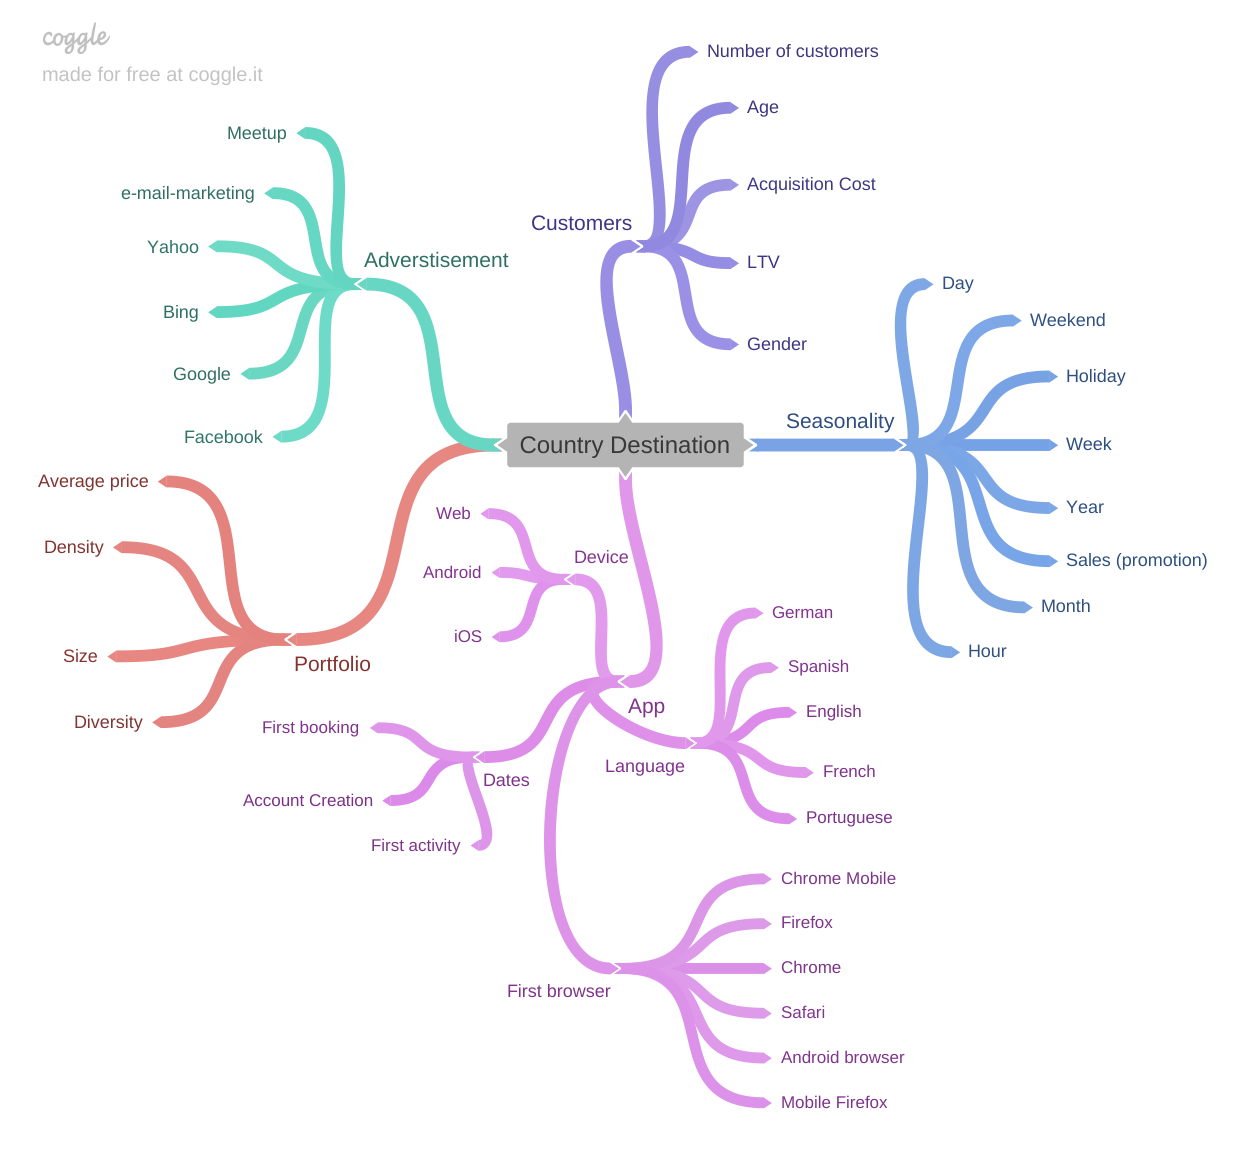

In [47]:
Image("images/HypothesesMindMap.png")

## 2.2. Hypotheses Generation

Based on the mind map above, we generated the hypotheses in this section.

### 2.2.1. App Hypotheses

### 2.2.2. Customers Hypotheses

### 2.2.3. Seasonality Hypotheses

## 2.3. Hypotheses Final List

## 2.4. Feature Engineering

We need variables which model the phenomenon. We derive a feature (derived) from an attribute (original from a dataset). The main motivation is to increase model performance.

- We must always think about how much time takes to happen something.
- We must break date into day, week, month, year and other time features as we may see below (date derivations).

In [48]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [49]:
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,2015-06-29,-unknown-,37,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [50]:
# days from first active up to first booking
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ) )
df2['days_from_first_active_until_booking'] = ( df2['date_first_booking'] - df2['first_active'] ).apply( lambda x: x.days )

# days from first active up to account created
df2['days_from_first_active_until_account_created'] = ( df2['date_account_created'] - df2['first_active'] ).apply( lambda x: x.days )

# days from account createad up to first booking
df2['days_from_account_created_until_first_booking'] = ( df2['date_first_booking'] - df2['date_account_created'] ).apply( lambda x: x.days )

# ================== First Active ==================

# year first active
df2['year_first_active'] = df2['first_active'].dt.year

# month first active
df2['month_first_active'] = df2['first_active'].dt.month

# day first active
df2['day_first_active'] = df2['first_active'].dt.day

# day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

# week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear

# ================== First Booking ==================

# year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

# month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

# ================== First Account Created =================

# year first booking
df2['year_account_created'] = df2['date_account_created'].dt.year

# month  account_created
df2['month_account_created'] = df2['date_account_created'].dt.month

# day  account_created
df2['day_account_created'] = df2['date_account_created'].dt.day

# day of week  account_created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year  account_created
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_1560/833517296.py:26: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear
/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_1560/833517296.py:43: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear
/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_1560/833517296.py:60: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


In [51]:
df2.shape

(207386, 35)

# 3. Feature Filtering and Selection

In [52]:
df3 = df2.copy()

## 3.1. Feature Filtering

In [53]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are not people older than 122    
df3 = df3[( df3['age'] > 15 ) & ( df3['age'] < 122 )]

# secs_elapsed - there is no possible 0 secs elapsed on website
df_sessions = df_sessions[df_sessions['secs_elapsed'] > 0]

## 3.2. Columns Selection

Based on sections 1.7.5 and 1.7.6, we chose the following columns to be removed. We must have the minimum number of columns in order to avoid model overfitting.

In [54]:
cols_drop_users = ["first_device_type", "first_browser", "affiliate_provider"]
cols_drop_sessions = ["action_detail", "action"]

df3 = df3.drop(cols_drop_users, axis=1)
df_sessions = df_sessions.drop(cols_drop_sessions, axis=1)

# 4. Exploratory Data Analysis (EDA)

In [55]:
df4 = df3.copy()

In [56]:
df4.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,year_first_booking,month_first_booking,day_first_booking,day_of_week_first_booking,week_of_year_first_booking,year_account_created,month_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,2015-06-29,-unknown-,37,facebook,0,en,direct,...,2015,6,29,0,27,2010,6,28,0,26
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,...,2015,6,29,0,27,2011,5,25,2,21
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,...,2010,8,2,0,31,2010,9,28,1,39
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,...,2012,9,8,5,36,2011,12,5,0,49
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,...,2010,2,18,3,7,2010,9,14,1,37


# 5. Data Preparation

In [57]:
df5 = df4.copy()

In [58]:
 # dummy variable
df5_dummy = pd.get_dummies(df5.drop(['id', 'country_destination'], axis=1))

# join id and country destination
df5 = pd.concat([df5[['id', 'country_destination']], df5_dummy], axis=1) 

In [59]:
df5.sample()

,id,country_destination,date_account_created,timestamp_first_active,date_first_booking,age,signup_flow,first_active,days_from_first_active_until_booking,days_from_first_active_until_account_created,...,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_untracked,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS
105264,0o878irj5k,NDF,2013-09-05,2013-09-05 20:47:55,2015-06-29,37,25,2013-09-05,662,0,...,0,0,0,0,0,1,0,0,0,1


# 6. Feature Selection

We must delete date type features in order to train the model. 

In [72]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active'] # original dates
df6 = df5.drop(cols_drop, axis=1)

# 7. Machine Learning Modeling

In [73]:
df7 = df6.copy()

## 7.1. Performance Metrics 

Since we have a multi-class problem and very imbalanced, in this project, we must aim for metrics which considers these characteristics.

#### Accuracy

Number of correct predictions over total number of predictions. 

- Number of correct predictions: sum of principal diagonal of the confusion matrix.
- Number of predictions: sum of all numbers of the confusion matrix.

Accuracy is biased towards a class with more available examples - and hence: more correct predictions. As we have a very imbalanced dataset, thus this is not the most proper metric to evaluate model performance. 

#### Precision

Number of correct predictions for each class over number of predictions for each class.

- Number of correct predictions for each class: intersection of class of the confusion matrix.
- Number of predictions for each class: sum of vertical numbers of a class.

We use this metric when there are classes more important than others. Although this metric is good for imbalanced/unbalanced problems, the precision is not the most important for us. We are not working with medical development, for instance.

#### Recall (Sensitivity)

Number of correct predictions for each class over number of total values for each class.

- Number of correct predictions for each class: intersection of class of the confunsion matrix.
- Number of total values for each class: sum of horizontal numbers of a class. 

We discard this metric because it is not good for imbalanced/unbalanced problems. 

#### F1-Score

Harmonious average between Precision and Recall metrics. This metric is applied as a combination of two classes (binary-class). Thus, it works very well when we are combining two classes. But our problem is multi-class, therefore this metric is not the most proper.

This metric summarize Precision and Recall. Thus, we discard this one for the same reasons discussed above. 

#### Kappa Score

It is used to measure the number of agreements between evaluators. The closer to 1, the higher the agreement between evaluators. For this project, we used this metric and our goal is a value higher than 75%. 

#### Balanced Accuracy

We need a one and only metric to evaluate the model performance. For this project, we used the balanced accuracy, since we have a very imbalanced dataset and this metric considers the accuracy of each class.

A little value means imbalanced dataset. As we balance our data, the value of this metrics increases.

## 7.2. Training and test datasets

As the data is too imbalanced (with "im": naturally without balance), we should not use accuracy as the main metric to evaluate model performance. 

In [74]:
X = df7.drop('country_destination', axis=1)
y = df7['country_destination'].copy()

In [75]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

In [76]:
x_train = X_train.drop('id', axis=1)
x_test = X_test.drop('id', axis=1)

## 7.3. Baseline Model

For a time series problem, the baseline model is an average one. For a classification problem, the baseline is a model which randomly estimates the classes we are looking at (country_destination).

In [77]:
# population is the response variable - it is in the alphabetic order for the classes
country_destination_list = df7['country_destination'].drop_duplicates().sort_values().tolist()

# number of samples generated randomly is the number of predictions we want = y_test.shape[0]
k_num = y_test.shape[0]

# number of classes - it is in the alphabetic order fot the classes
country_destination_weights = df7['country_destination'].value_counts( normalize=True ).sort_index().tolist()

# predictions
yhat_random = random.choices( population=country_destination_list,  
                              weights=country_destination_weights,
                              k=k_num )
len( yhat_random )

41319

### 7.3.1. Baseline Performance

Accuracy: 0.4287615866792517
Balanced Accuracy: 0.08415911955907879
Kappa Score: 0.004086928372552867
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       265
          DE       0.01      0.01      0.01       234
          ES       0.00      0.01      0.00       385
          FR       0.03      0.03      0.03       971
          GB       0.02      0.02      0.02       457
          IT       0.02      0.02      0.02       553
         NDF       0.58      0.58      0.58     23927
          NL       0.00      0.00      0.00       143
          PT       0.00      0.00      0.00        54
          US       0.30      0.30      0.30     12249
       other       0.05      0.05      0.05      1980

    accuracy                           0.43     41319
   macro avg       0.08      0.08      0.08     41319
weighted avg       0.43      0.43      0.43     41319



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

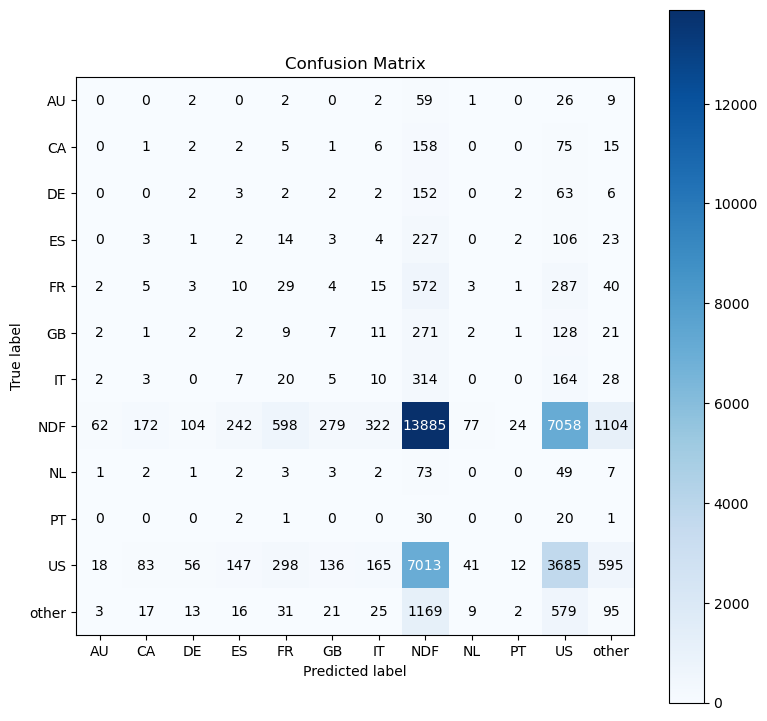

In [90]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification report
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(9,9))

- Accuracy: 42%.
- Balanced Accuracy: 8.3%. This metric is more realistic than accuracy since we have an imbalanced dataset.
- Kappa Score is too little. 
- The majority of predictions are biased to be US, even it is not the correct one.

## 7.4. Neural Network - MLP

Firstly, we need to encode the response variable to work with neural network:

In [79]:
y_train

38694      ES
115575    NDF
85496      ES
180102    NDF
166815    NDF
         ... 
65191      US
80151     NDF
136865     FR
113515    NDF
14173      US
Name: country_destination, Length: 165274, dtype: object

In [80]:
# instantiate encoder
ohe = pp.OneHotEncoder()

# y train for neural network
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [81]:
y_train_nn

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [88]:
# MUST: number of neurons in the first layer must be higher than this value 
# Use the next higher number that is multiple of two: 2^2, 2^3, 2^4, etc. 
x_train.shape[1]

71

In [82]:
# MUST: number of neurons in the last layer = number of classes
y_train_nn.shape[1]

12

Artifical Neural Network (ANN) - Multi-Layer Perceptron (MLP)

- We used softmax in the final layer because this one is good when the response variable is categorical. 
- Accuracy is the main metric to evaluate a classification model.

In [83]:
 # model definition
model = ml.Sequential()

# first layer
model.add(l.Dense(128, input_dim=x_train.shape[1], activation='relu'))

# last layer
model.add(l.Dense(12, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(x_train, y_train_nn, epochs=100)

Epoch 1/100
5165/5165 [==============================] - 5s 921us/step - loss: 5.3276 - accuracy: 0.7891
Epoch 2/100
5165/5165 [==============================] - 5s 873us/step - loss: 1.8821 - accuracy: 0.8080
Epoch 3/100
5165/5165 [==============================] - 5s 879us/step - loss: 1.0143 - accuracy: 0.8278
Epoch 4/100
5165/5165 [==============================] - 5s 963us/step - loss: 0.6823 - accuracy: 0.8518
Epoch 5/100
5165/5165 [==============================] - 5s 918us/step - loss: 0.5322 - accuracy: 0.8713
Epoch 6/100
5165/5165 [==============================] - 5s 882us/step - loss: 0.5040 - accuracy: 0.8728
Epoch 7/100
5165/5165 [==============================] - 5s 930us/step - loss: 0.4981 - accuracy: 0.8732
Epoch 8/100
5165/5165 [==============================] - 5s 985us/step - loss: 0.4981 - accuracy: 0.8733
Epoch 9/100
5165/5165 [==============================] - 4s 848us/step - loss: 0.4969 - accuracy: 0.8734
Epoch 10/100
5165/5165 [==============================]

5165/5165 [==============================] - 5s 877us/step - loss: 0.4905 - accuracy: 0.8737
Epoch 79/100
5165/5165 [==============================] - 5s 882us/step - loss: 0.4911 - accuracy: 0.8737
Epoch 80/100
5165/5165 [==============================] - 5s 887us/step - loss: 0.4907 - accuracy: 0.8738
Epoch 81/100
5165/5165 [==============================] - 5s 875us/step - loss: 0.4907 - accuracy: 0.8737
Epoch 82/100
5165/5165 [==============================] - 5s 874us/step - loss: 0.4911 - accuracy: 0.8737
Epoch 83/100
5165/5165 [==============================] - 5s 880us/step - loss: 0.4906 - accuracy: 0.8737
Epoch 84/100
5165/5165 [==============================] - 5s 878us/step - loss: 0.4905 - accuracy: 0.8738
Epoch 85/100
5165/5165 [==============================] - 5s 896us/step - loss: 0.4906 - accuracy: 0.8738
Epoch 86/100
5165/5165 [==============================] - 4s 869us/step - loss: 0.4906 - accuracy: 0.8738
Epoch 87/100
5165/5165 [==============================] - 5

### 7.4.1. NN Single Performance

In [84]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction - going back to the categorical attributes 
# real prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

1292/1292 [==============================] - 1s 590us/step


Accuracy: 0.8739335632601198
Balanced Accuracy: 0.16666666666666666
Kappa Score: 0.7665744099380338


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        85
          CA       0.00      0.00      0.00       224
          DE       0.00      0.00      0.00       160
          ES       0.00      0.00      0.00       363
          FR       0.00      0.00      0.00       782
          GB       0.00      0.00      0.00       366
          IT       0.00      0.00      0.00       444
         NDF       1.00      1.00      1.00     19177
          NL       0.00      0.00      0.00       121
          PT       0.00      0.00      0.00        31
          US       0.70      1.00      0.82      9710
       other       0.00      0.00      0.00      1591

    accuracy                           0.87     33054
   macro avg       0.14      0.17      0.15     33054
weighted avg       0.79      0.87      0.82     33054



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

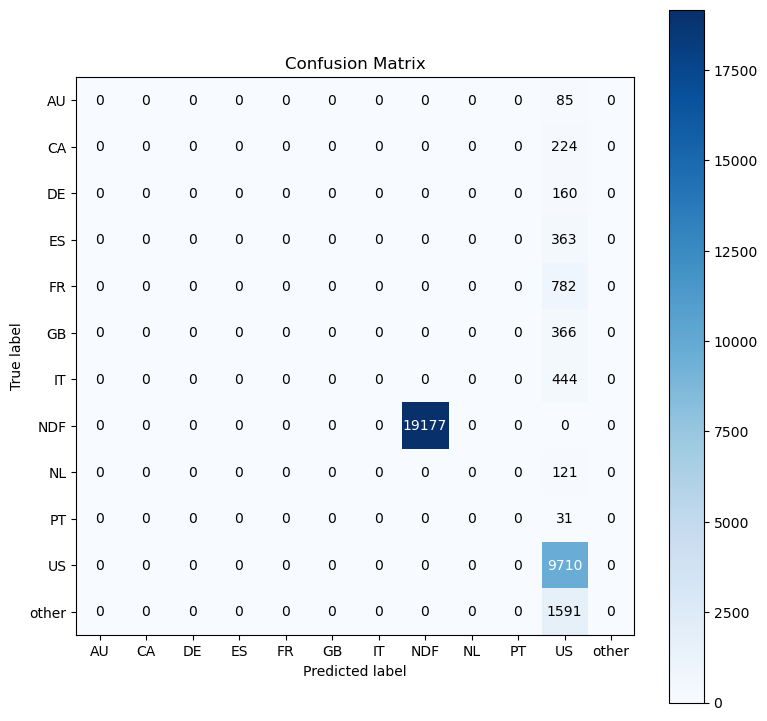

In [89]:
# Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuray
balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification report
print(m.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(9,9))

- Accuracy of 62% is a good one, but... 
- The model chose US even when the true class was other countries.
- The neural network is biased towards the class with more available examples: US.


- The majority of predictions for US were correct. For true US, the wrong predictions were: CA (1), DE (5), ES (1), FR (7), GB (4) and IT (2). 
- AU: accuracy = 0%. CA: accuracy = 0%. All predictions for AU and CA were wrong.

Accuracy basically is: how much right predictions I have chose correctly over the amount of predictions I did. 

- Balanced Accuracy of 10.8% is much more realistic. We want to increase it to values around 85%.
- Kappa Score is 24.5%. We want values higher than 70%.

### 7.4.2. NN Cross-Validation Performance

#### Theory

We may understand **selection bias** as the bias with the following characteristics:

1. The luck of selecting a good training dateset. 
2. Some behaviors may be hidden in datasets which were not selected.
3. Different behaviors for training and test datasets. 

- We must avoid selection bias because we want our model learns the most from the data patterns. In order to minimize this bias, we are going to split out data into several training and test datasets. This technique is named Cross-Validation. 

- The split is made randomly for a classification problem. However, when we work with time series, this sampling must not be random, since the time is very important to this type of problem.

- Cross-Validation is not very good for imbalanced/unbalanced data, since we have majority classes and probably the majority class will be chosen more times through random sampling.

#### Practice

- **kfold.split()** keeps the proportion of classes.
- **train_ix:** index of training dataset.
- **val_ix:** index of validation ("test") dataset.

In [86]:
 # generate k-fold
num_folds = 5 # shuffle = True: the split is done randomly
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    print( 'Fold Number: {}/{}'.format(i, num_folds))
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()

    # model definition
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
    model.add(l.Dense(12, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # training model
    model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)

    # prediction
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn)
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
    
    i += 1

Fold Number: 1/5
1033/1033 [==============================] - 1s 699us/step
Fold Number: 2/5
1033/1033 [==============================] - 1s 797us/step
Fold Number: 3/5
1033/1033 [==============================] - 1s 777us/step
Fold Number: 4/5
1033/1033 [==============================] - 1s 769us/step
Fold Number: 5/5
1033/1033 [==============================] - 1s 791us/step


In [87]:
pd.DataFrame( {'Average Balanced Accuracy': np.round( np.mean( balanced_acc_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( balanced_acc_list  ), 4 ).astype( str ),
                'Average Kappa': np.round( np.mean( kappa_acc_list ), 4 ).astype( str ) + ' +/- ' + np.round( np.std( kappa_acc_list ), 4 ).astype( str ) }, index=[0] )


,Average Balanced Accuracy,Average Kappa
0,0.17 +/- 0.0,0.7664 +/- 0.0001
